In [16]:
from fastai.vision.all import *
from pathlib import Path
import kaggle
import fastkaggle
from fastcore.parallel import *

#set_seed(42)

#path.ls()

In [9]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [10]:
creds='{"username":"atikarahmanpaddo","key":"1c7600647915e2491d5170e9995d948e"}'

In [12]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [18]:
path = Path('paddy-disease-classification')

#path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [19]:
if not iskaggle and not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 1.02G/1.02G [00:16<00:00, 66.2MB/s]


In [22]:
if iskaggle:
    path = Path('../input/paddy-disease-classification')
    ! pip install -q datasets

In [23]:
!ls {path}

sample_submission.csv  test_images  train.csv  train_images


In [24]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

(480, 640)


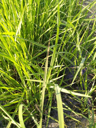

In [25]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [26]:
def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

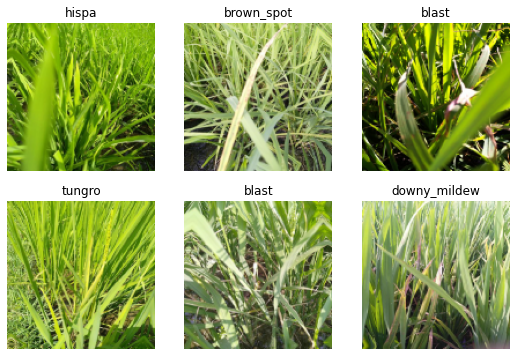

In [27]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)

In [28]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /home/jupyter-apaddo/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


SuggestedLRs(valley=0.001737800776027143, slide=0.00363078061491251)

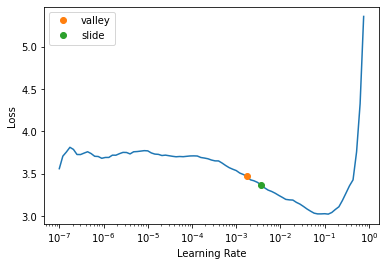

In [29]:
learn.lr_find(suggest_funcs=(valley, slide))

In [30]:
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.718692,1.242617,0.394522,00:11


epoch,train_loss,valid_loss,error_rate,time
0,1.124333,0.807646,0.274387,00:12
1,0.767394,0.474282,0.164344,00:12
2,0.544111,0.411243,0.129745,00:12


In [31]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

In [32]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

TensorBase([7, 8, 7,  ..., 8, 7, 5])

In [33]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [34]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0            hispa
1           normal
2            hispa
3            blast
4            blast
           ...    
3464    dead_heart
3465         hispa
3466        normal
3467         hispa
3468    dead_heart
Name: idxs, Length: 3469, dtype: object